## Pollen Lab Notebook

This notebook shows how to train a convolutional network for pollen classification.

In [23]:
!git clone https://github.com/jachansantiago/pollenlab.git
%cd pollenlab
!tar -xzf images.tgz
!pip install tensorflow_addons

fatal: destination path 'pollenlab' already exists and is not an empty directory.
/content/pollenlab/pollenlab


In [22]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications import VGG16, MobileNetV2

from tensorflow_addons.metrics import F1Score

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Dataset Functions

Here we are using the [tf.keras.preprocessing.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function to load the dataset from the `images/` directory. The labels of the images are inferred by the name of the folder that contains them.

```
images/
...NP/
......a_image_1.jpg
......a_image_2.jpg
...P/
......b_image_1.jpg
......b_image_2.jpg
```



In [5]:
def normalize_image(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    batch_size=32,
    image_size=(90, 90),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
).map(normalize_image)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    batch_size=32,
    image_size=(90, 90),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
).map(normalize_image)


Found 5587 files belonging to 2 classes.
Using 4470 files for training.
Found 5587 files belonging to 2 classes.
Using 1117 files for validation.


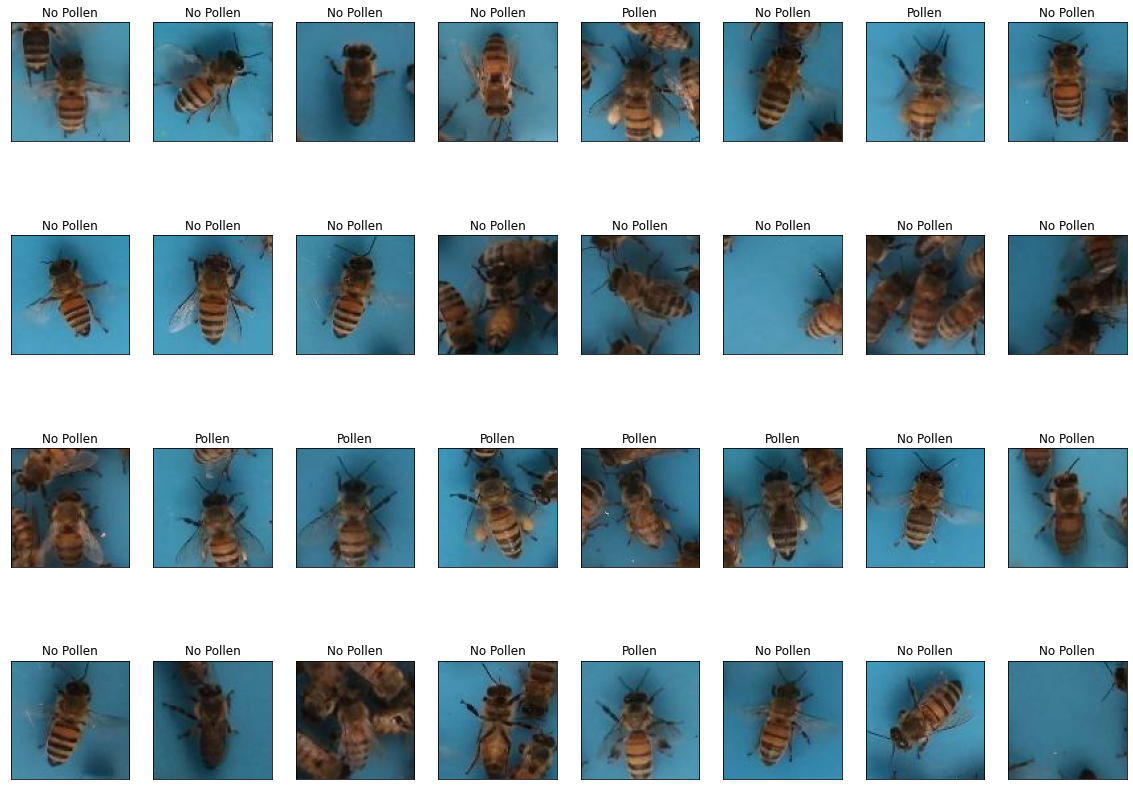

In [26]:
fig, ax = plt.subplots(4, 8, figsize=(20, 15))
axes = ax.ravel()

gen = iter(train_dataset)
sample_batch = next(gen)

for i, (image, label) in enumerate(zip(sample_batch[0], sample_batch[1])):
    axes[i].imshow(image)
    label_str = "Pollen" if label[0] else "No Pollen"
    axes[i].set_title("{}".format(label_str))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

## Model Functions

In [27]:
class Classifier(tf.keras.Model):
    def __init__(self, base_model, filters=64, classes=2):
        super(Classifier, self).__init__()
        self.backbone = base_model
        self.flatten = Flatten(name='flatten')
        self.dense = Dense(filters,activation='relu')
        if classes == 1:
            self.classifier = Dense(classes, activation="sigmoid")
        else:
            self.classifier = Dense(classes, activation="softmax")
        self.model_name = "Classifier"
        
    def call(self, data):
        x = data
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.dense(x)
        id_class = self.classifier(x)
        return id_class

### MobileNetV2

In this notebook we are using a MobileNetV2 which comes with keras. You can find other pre-made models on [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications). More details about the models [here](https://keras.io/api/applications/).


Some notations:

The input is represented by $X$. The labels or the target by $y$, where $y$ is the ground truth and $\hat{y}$ is the prediction by the model.

In this notebook we are using a Convolutional Neural Networks.


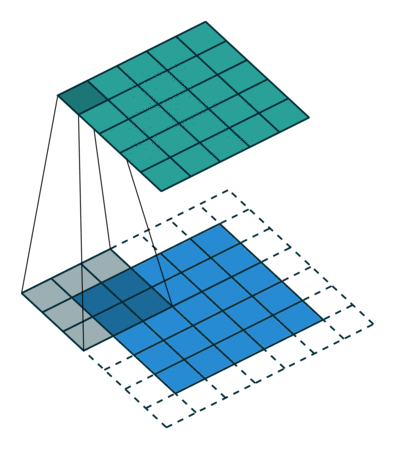

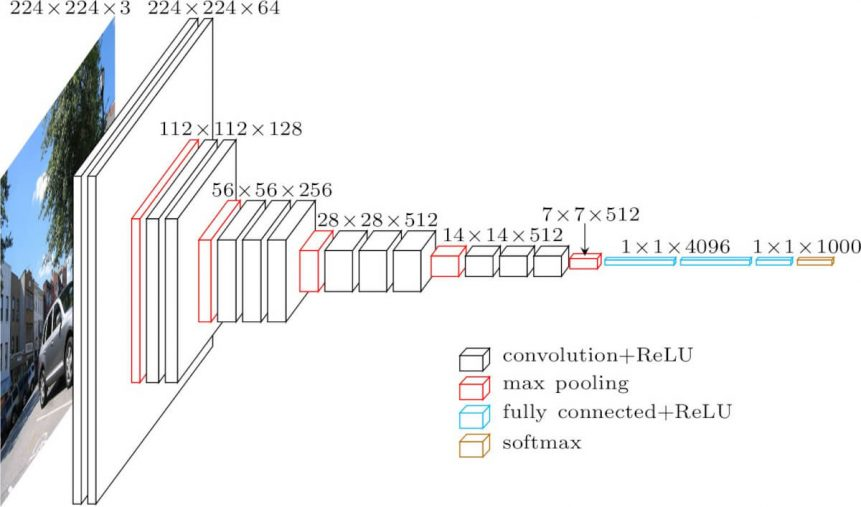

In [46]:
backbone = MobileNetV2(include_top=False, input_shape=(90, 90, 3))
model_input = backbone.input
model_out = backbone.get_layer("block_6_expand_relu").output
backbone = Model(model_input, model_out)

In [47]:

model = Classifier(backbone, classes=1)

The optimization loss of this model is the binary cross-entropy. 

$$
loss = - \frac{1}{N} \sum_i^N y_i \log{\hat{y}_i} + (1 - y_i) \log (1 - \hat{y}_i) 
$$



In [48]:
model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['accuracy', F1Score(num_classes=1, threshold=0.5)])

In [49]:
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
history_df = pd.DataFrame(history.history, index=history.epoch)

Epoch 1/20
140/140 [==============================] - 12s 67ms/step - loss: 0.5654 - accuracy: 0.9096 - f1_score: 0.8008 - val_loss: 0.6154 - val_accuracy: 0.8317 - val_f1_score: 0.4689
Epoch 2/20
140/140 [==============================] - 9s 63ms/step - loss: 0.0517 - accuracy: 0.9839 - f1_score: 0.9656 - val_loss: 0.5985 - val_accuracy: 0.8335 - val_f1_score: 0.4775
Epoch 3/20
140/140 [==============================] - 9s 62ms/step - loss: 0.0241 - accuracy: 0.9915 - f1_score: 0.9819 - val_loss: 0.3709 - val_accuracy: 0.9042 - val_f1_score: 0.7540
Epoch 4/20
140/140 [==============================] - 9s 63ms/step - loss: 0.0071 - accuracy: 0.9987 - f1_score: 0.9972 - val_loss: 0.3563 - val_accuracy: 0.9141 - val_f1_score: 0.7848
Epoch 5/20
140/140 [==============================] - 9s 63ms/step - loss: 0.0074 - accuracy: 0.9975 - f1_score: 0.9948 - val_loss: 0.3406 - val_accuracy: 0.9096 - val_f1_score: 0.7710
Epoch 6/20
140/140 [==============================] - 9s 61ms/step - loss:

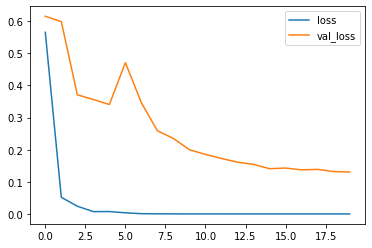

In [50]:
plt.plot(history_df["loss"], label="loss");
plt.plot(history_df["val_loss"], label="val_loss");
plt.legend();

In [51]:
y_pred = []  # store predicted labels
y_true = []  # store true labels
X_valid = []

for image_batch, label_batch in valid_dataset:
    X_valid.append(image_batch)
    
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(preds)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
images = tf.concat([item for item in X_valid], axis = 0)

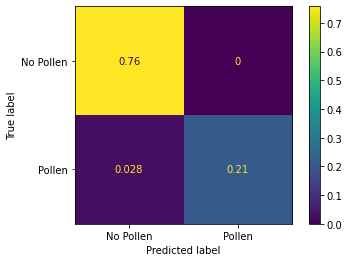

In [52]:
cm = confusion_matrix(correct_labels, predicted_labels > 0.5, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=["No Pollen", "Pollen"]).plot()

In [53]:
print(classification_report(correct_labels, predicted_labels > 0.5 ))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       846
         1.0       1.00      0.89      0.94       271

    accuracy                           0.97      1117
   macro avg       0.98      0.94      0.96      1117
weighted avg       0.97      0.97      0.97      1117



In [54]:
model.save("pollen_model.tf")

INFO:tensorflow:Assets written to: pollen_model.tf/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#### Check Predictions

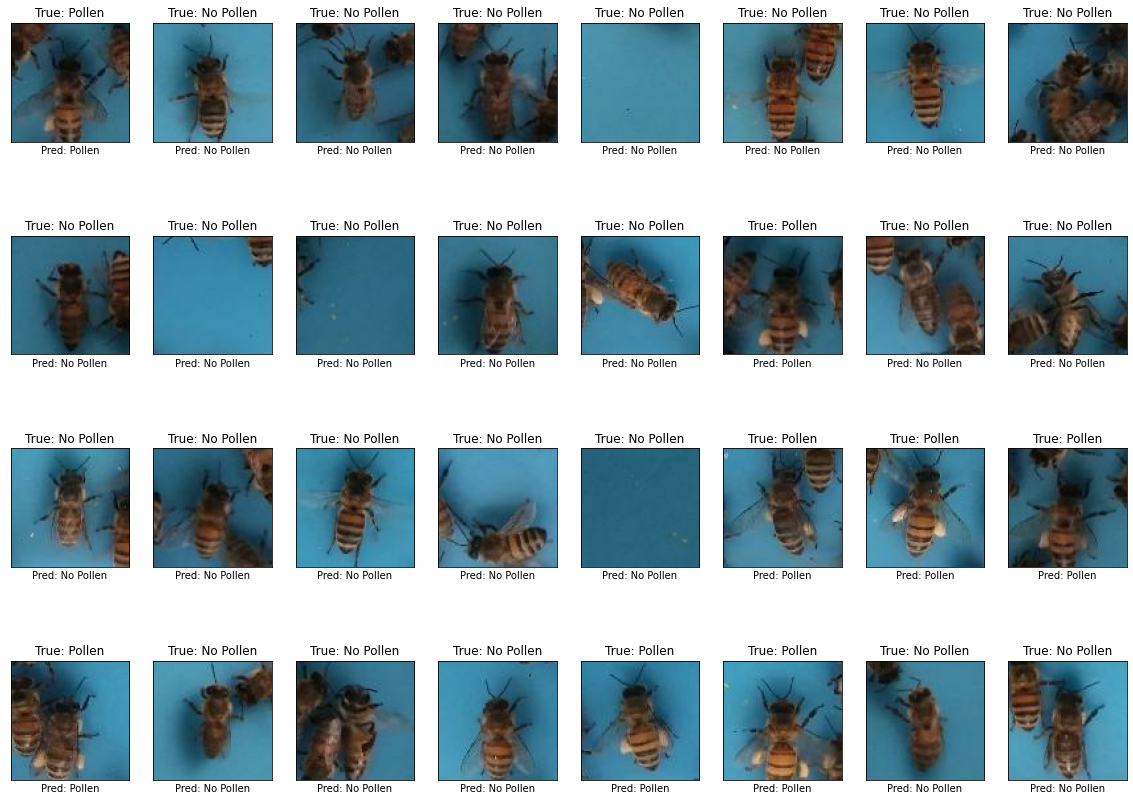

In [55]:
random_idx = np.random.permutation(len(images))
random_idx = random_idx[:32]
fig, ax = plt.subplots(4, 8, figsize=(20, 15))
axes = ax.ravel()

for i, idx in enumerate(random_idx):
    axes[i].imshow(images[idx])
    true_label = "Pollen" if correct_labels[idx] > 0.5 else "No Pollen"
    pred_label = "Pollen" if predicted_labels[idx] > 0.5 else "No Pollen"
    
    title = true_label + pred_label
    axes[i].set_title("True: {}".format(true_label))
    axes[i].set_xlabel("Pred: {}".format(pred_label))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

#### Check Hard Cases

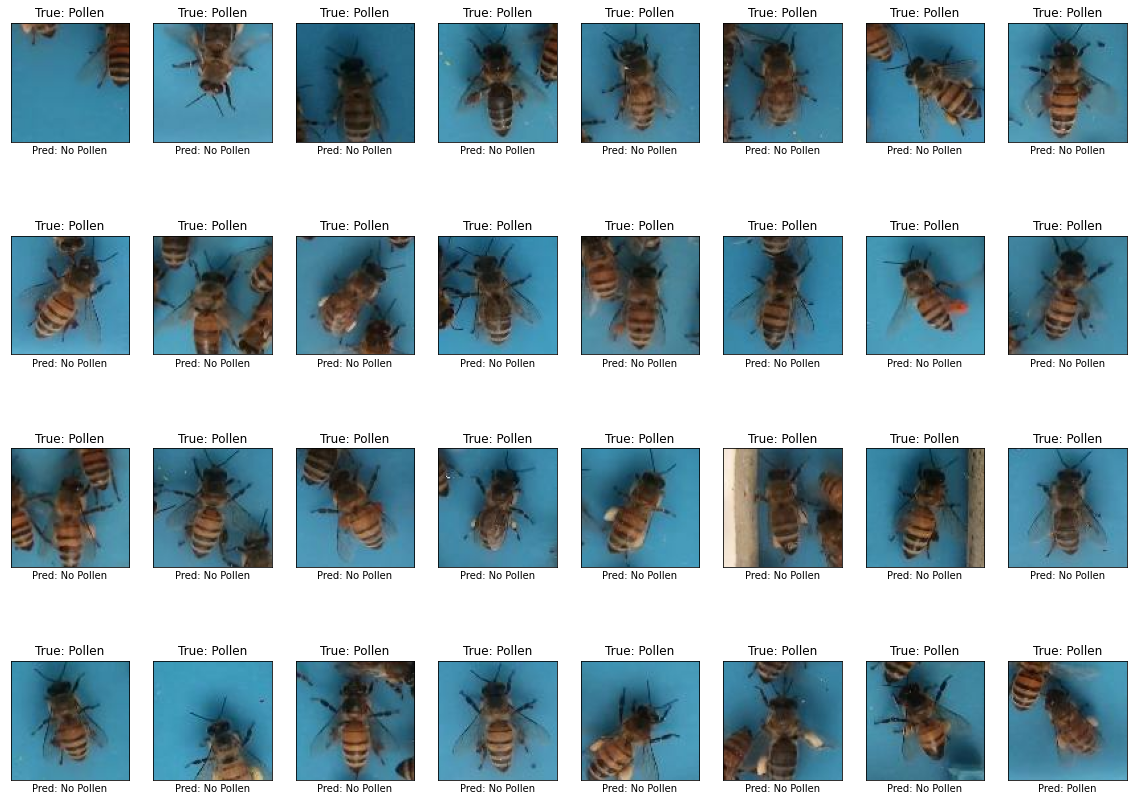

In [56]:
errors = (correct_labels - predicted_labels)**2
hard_cases_indxes = tf.argsort(errors, direction="DESCENDING", axis=0)
hard_cases_indxes = tf.reshape(hard_cases_indxes, -1)

fig, ax = plt.subplots(4, 8, figsize=(20, 15))
axes = ax.ravel()

for i, idx in enumerate(hard_cases_indxes[:32]):
    axes[i].imshow(images[idx])
    true_label = "Pollen" if correct_labels[idx] > 0.5 else "No Pollen"
    pred_label = "Pollen" if predicted_labels[idx] > 0.5 else "No Pollen"
    
    title = true_label + pred_label
    axes[i].set_title("True: {}".format(true_label))
    axes[i].set_xlabel("Pred: {}".format(pred_label))
    axes[i].set_xticks([])
    axes[i].set_yticks([])